In [1]:
using BandedMatrices, BlockBandedMatrices, BlockArrays, LinearAlgebra, SparseArrays, IntervalArithmetic, Plots, LaTeXStrings, Serialization, Polynomials

In [2]:
# guaranteed (and fast) multiplication with between BandedBlockBanded Matrix and adjoint matrix
Base.:*(A::BandedBlockBandedMatrix{Interval{Float64}}, B::Adjoint) = A*Matrix(B)
# Base.:*(A::Adjoint,N::BlockedMatrix{Interval{Float64}}) = Matrix(A)*B

In [3]:
b̲ = interval(0)
b̄ = interval(30)
K = 32
a = interval(4)
α = interval(4)
bK = (b̲ + b̄)/interval(2) .+cos.(interval.(Float64, collect(K:-1:0).//(K))*interval(π))*(b̄ - b̲)/interval(2)
sqK = sqrt.(a^2 .+bK.^2);

### Polynomial approximation of $\sqrt{a^2+b^2}$ ###

We first compute an approximate polynomial $p:[\underline{b},\bar{b}]\to \mathbb{R}$ of degree $K$ such that

$$\sqrt{a^2+b^2} = p(b) + \varepsilon(b)$$

with $\varepsilon$ a small quantyfiable residual.

In [4]:
θK = interval.(Float64, collect(K:-1:0).//(K))*interval(π)
xK = cos.(θK)
indK = interval.(collect(0:K))
# MK maps a K+1 Chebyshev coefficients to evaluation at K+1 Chebyshev nodes
MK = cos.(θK*indK')
MK[:,2:end] *=interval(2)
# MKinv maps the evalation at Chebyshev at K+1 nodes to K+1 Chebyshev coefficients
MKinv = (cos.(θK*indK')/interval(K))'
MKinv[:,1]/=interval(2)
MKinv[:,end]/=interval(2)
MKinv[end,:]/=interval(2);

In [5]:
# same for Chebyshev polynomials of degree 2K
θ2K = interval.(Float64, collect(2*K:-1:0).//(2*K))*interval(π)
x2K = cos.(θ2K)
ind2K = interval.(collect(0:2K))
M2K = cos.(θ2K*ind2K')
M2K[:,2:end] *=interval(2)
M2Kinv = (cos.(θ2K*ind2K')/interval(2K))'
M2Kinv[:,1]/=interval(2)
M2Kinv[:,end]/=interval(2)
M2Kinv[end,:]/=interval(2);

In [6]:
p = vcat(MKinv*sqK, zeros(Interval{Float64},K));
sq2K = M2K*p;

We aim to solve the fixed point problem

$$F(g) = g^2 - a^2 - b^2 = 0$$

in $\ell^1$, i.e. the $\ell^1$-space induce by the $\ell^1$-norm

$$\|g\|_1 = \sum _{k=0}^{\infty}\|g_k\|\leq \frac{1}{2}\|g\|_{\infty} \qquad g = \sum_{k=0}g_k T_k.$$

Since $DF(g) = 2g$, we choose a fixed-point problem

$$T(g) = \mathrm{id} - \bar{\omega}F(g)$$

where $\bar{\omega}\approx (2p)^{-1}$

In [7]:
ω̄ = vcat(MKinv*(interval(1) ./(interval(2)*sqK)), zeros(Interval{Float64},K));

We apply the radii-polynomial approach and find

$$\|T(g) - f\|_1 = \|\bar\omega F(p)\|_1 \leq \|\bar{\omega}\|_1 \|p^2 - b^2 - a^2\|_1 =: Y,$$

$$\|DT(\bar{g})\|_1 = \|\mathrm{id} - \bar{\omega}DF(g)\|_1 = \|1 - 2\bar{\omega}p\|_1 =: Z_1, $$

$$\|DT^2(\bar{g})\|_1 = \|\bar{\omega}D^2F(g)\|_1 = 2\|\bar{\omega}\|_1 =: Z_2 .$$

In [8]:
b2K = (b̲ + b̄)/interval(2) .+cos.(interval.(Float64, collect(2*K:-1:0).//(2*K))*interval(π))*(b̄ - b̲)/interval(2)
Y = sum(abs.(ω̄)).*sum(abs.(M2Kinv*(sq2K.^2 - b2K.^2 .- a.^2)))
Z₁ = sum(abs.(M2Kinv*(interval(1.0) .- interval(2)*(M2K*ω̄).*(M2K*p))))
Z₂ = interval(2)*sum(abs.(ω̄))
ε_norm = interval(2)*interval.(sup((interval(1) - Z₁ - sqrt(interval(1) - interval(2)*Z₁ + Z₁^2 - interval(2)*Y*Z₂))/Z₂))

[6.60655e-09, 6.60656e-09]_com

### Enclosure of $\lambda_b$ ###

In [9]:
Ns = collect(500:-2:0);

In [10]:
# implements the Laplacian on each mode
function laplacian(m, N)
    n = 1:N
    c = -interval(4)*sqrt.(interval.(n.*(m .+ n)))
    return BandedMatrix(1 => c)
end

# implements the multiplication by r² on each mode
function sq_mult(m, N)
    n = 0:(N-1)
    A = -sqrt.(interval.((n .+ 1).*(m +1 .+n)))
    n = 0:N
    B = interval.((m + 1 .+ 2 .*n))
    n = 1:N
    C = -sqrt.(interval.(n.*(n .+ m)))
    return BandedMatrix(-1 => A, 0 => B, 1 => C)
end

# shifts down basis functions in one mode to twice-below mode and multiply by r²
function shift_down(m, N)
    n = 0:(N-2)
    A = sqrt.(interval.((n .+ 1).* (n .+ 2)))
    n = 0:(N-1)
    B = -interval(2)*sqrt.(interval.((n .+ m).* (n .+ 1)))
    n = 0:N
    C = sqrt.(interval.((n .+ m).* (n .+ m .- 1)))
    return BandedMatrix(-2 => A, -1 => B, 0 => C) #/interval(2)
end

# shifts down basis functions in one mode to twice-above mode and multiply by r²
function shift_up(m, N)
    n = 0:N
    A = sqrt.(interval.((m + 1 .+ n).*(m + 2 .+ n)))
    n = 1:N
    B = -interval(2)*sqrt.(interval.(n.*(m + 1 .+ n)))
    n = 2:N
    C = sqrt.(interval.(n.*(n .- 1)))
    return BandedMatrix(0 => A, 1 => B, 2 => C) #/interval(2)
end

# implements the operator r³∂ᵣ on each mode

function cubic_drift(m, N)
    n = 0:(N-1)
    A = - interval.(m .+2 .*n ) .*sqrt.(interval.((n.+1).*(m+1 .+n)))
    n = 0:N
    B = interval.(m + m^2 .+ 2 .*n.*(1 +3*m .+ 3*n))
    n = 1:N
    C = interval.(2 - 3*m .- 6 .*n).*sqrt.(interval.(n.*(n .+ m)))
    n = 2:N
    D = interval(2)*sqrt.(interval.(n .*(n .- 1).*(m - 1 .+n).*(m.+n)))
    return BandedMatrix(-1 => A, 0 => B, 1 => C , 2=> D)
end

# implements the operator r∂ᵣ on each mode

function linear_drift(m, N)
    n = 0:N
    B = interval.(m .+ 2 .*n)
    n = 1:N
    C = -interval(2).*sqrt.(interval.(n.*(n .+ m)))
    return BandedMatrix(0 => B, 1 => C)
end

linear_drift (generic function with 1 method)

In [11]:
# implements L = (αr - ar³)∂ᵣ+ Δ
function build_L(Ns)
    NS = vcat(Ns[1]+1, Ns);
    cols = reverse(sort(vcat(Ns[1]+3, Ns.+1, Ns.+1)))
    rows = reverse(sort(vcat(NS[1]+3, NS.+1, NS.+1)))
    # cols = rows = reverse(sort(vcat(Ns.+1, Ns.+1)))
    L = BandedBlockBandedMatrix(Zeros(Interval{Float64}, sum(rows),sum(cols)), rows,cols, (0,0), (3, 3))
    L[Block(1,1)] = (α*linear_drift(0, cols[1]+4) - a*cubic_drift(0, cols[1]+4) + laplacian(0, cols[1]+4))[1:rows[1],1:cols[1]]
    for m=1:length(Ns)
        L[Block(2*m,2*m)] = L[Block(2*m+1,2*m+1)] = (α*linear_drift(2*m, cols[2*m]+4) - a*cubic_drift(2*m, cols[2*m]+4) + laplacian(2*m, cols[2*m]+4))[1:rows[2*m],1:cols[2*m]]
    end
    return L
end

# implements B = cos(2ψ)∂ψ
function build_B(Ns)
    NS = vcat(Ns[1]+1, Ns);
    cols = reverse(sort(vcat(Ns[1]+3, Ns.+1, Ns.+1)))
    rows = reverse(sort(vcat(NS[1]+3, NS.+1, NS.+1)))
    # cols = rows = reverse(sort(vcat(Ns.+1, Ns.+1)))
    B = BandedBlockBandedMatrix(Zeros(Interval{Float64}, sum(rows),sum(cols)), rows,cols, (1,1), (3, 3))
    for m=1:length(Ns)
        B[Block(2*m,2*m+1)] = interval(2*m)*(sq_mult(2*m, cols[2*m]+4))[1:rows[2*m],1:cols[2*m]]
        B[Block(2*m+1,2*m)] = -interval(2*m)*(sq_mult(2*m, cols[2*m]+4))[1:rows[2*m],1:cols[2*m]]
    end
    return B
end

# implements A = r²cos(2ψ)∂ψ
function build_A(Ns)
    NS = vcat(Ns[1]+1, Ns);
    cols = reverse(sort(vcat(Ns[1]+3, Ns.+1, Ns.+1)))
    rows = reverse(sort(vcat(NS[1]+3, NS.+1, NS.+1)))
    # cols = rows = reverse(sort(vcat(Ns.+1, Ns.+1)))
    A = BandedBlockBandedMatrix(Zeros(Interval{Float64}, sum(rows),sum(cols)), rows,cols, (3,3), (3, 3))
    A[Block(1,3)] = (shift_down(2, cols[1]+4))[1:rows[1],1:cols[2]]
    for m=1:length(NS)
        if m<length(Ns)
            A[Block(2*m,2*m+3)] = interval( m+1)*(shift_down(2*m+2, cols[2*m]+4))[1:rows[2*m],1:cols[2*m+2]]
            A[Block(2*m+1,2*m+2)] = -interval(m+1)*(shift_down(2*m+2, cols[2*m]+4))[1:rows[2*m],1:cols[2*m+2]]
        end
        if m>1
            A[Block(2*m,2*m-1)] = interval(m-1)*(shift_up(2*m-2,cols[2*m-2]+4))[1:rows[2*m],1:cols[2*m-2]]
            A[Block(2*m+1,2*m-2)] = -interval(m-1)*(shift_up(2*m-2, cols[2*m-2]+4))[1:rows[2*m],1:cols[2*m-2]]
        end
    end
    return A
end

build_A (generic function with 1 method)

In [12]:
L = build_L(Ns)
A = build_A(Ns)
B = build_B(Ns);

In [13]:
NS = vcat(Ns[1]+1, Ns)
cols = reverse(sort(vcat(Ns[1]+3, Ns.+1, Ns.+1)))
rows = reverse(sort(vcat(NS[1]+3, NS.+1, NS.+1)))
Q = BlockVector(zeros(Interval{Float64}, sum(rows)), rows)
Q[Block(1)[1]] = α - interval(2)*a
Q[Block(1)[2]] = interval(2)*a
QK = zeros(Interval{Float64}, (K+1, sum(rows)))
ūK = zeros(Interval{Float64},(K+1,sum(cols)));

In [14]:
Threads.@threads for k=1:K+1
    q = copy(Q)
    # println(k)
    𝔏 =  (mid(sqK[k])*mid.(sparse(A))+mid(bK[k])*mid.(sparse(B)) + mid.(sparse(L)))[2:end,:];
    q[Block(3)[1]] = sqK[k]*sqrt(interval(2))
    QK[k,:] = q 
    ūK[k,:] = collect(interval.(𝔏 \ mid.(q[2:end])));
end

In [15]:
ū2K = M2K*vcat(MKinv*ūK, zeros(Interval{Float64},(K, sum(cols))));

In [16]:
Q̄2K = M2K*vcat(MKinv*QK, zeros(Interval{Float64},(K, sum(rows))));

Recall that $\mathcal{L} = L + \sqrt{a^2+b^2}A + b B$ with

\begin{align*}
    L &= (\alpha r - a r^3)\partial_r +\Delta\\
    A &= r^2\cos(2\psi)\partial_{\psi}\\
    B &= r^2\partial_{\psi}
\end{align*}

Given a polynomial interpolation $\bar{u}_b$ in $b$ of our approximate solutions at Chebyshev nodes, we first define $\bar{\lambda}$ as

$$\bar{\lambda}_b = -P_0(L\bar{u}_b + p(b)A\bar{u}_b + bB\bar{u}_b - \bar{Q}_b)$$

with

$$\bar{Q}_b(r, \psi) = \alpha - 2ar^2+p(b)r^2\sin(2\psi).$$

Simmilary we compute the error

$$\delta_1 = \sup_{b}\|(P_0^{\perp}(L\bar{u}_b + p(b)A\bar{u}_b+ bB\bar{u}_b - \bar{Q}(b)))/W\|_{\infty}$$

In [17]:
ϵ2K = Matrix(((L*ū2K')' + sq2K.*(A*ū2K')' + b2K.*(B*ū2K')') - Q̄2K);
λ̄2K = -ϵ2K[:,1]
ϵ2K[:,1] .= interval(0);

In [18]:
suppsi = deserialize("suppsi");

In [19]:
ϵ_coeffs = M2Kinv*ϵ2K
ϵ_coeffs[2:end,:] *= interval(2)
δ₁ = sum(abs.(ϵ_coeffs).*collect(suppsi)')

[8.23392e-05, 8.24232e-05]_com

We then have the following errors from the polynomial approximation
$$\delta_2 = \sup_b|\epsilon(b)|\|(A\bar{u} _b) /W\| _{\infty}$$
and
$$\delta_3 = \sup_{b}\|(\bar{Q}_b - Q_b)/W\|_{\infty} \leq \sup_b|\epsilon(b)||\|r^2\sin(2\psi)/W\|_{\infty}$$

In [20]:
δ₂ = ε_norm*sum(abs.(A*ū2K').*collect(suppsi))

[1.36635e-06, 1.36637e-06]_com

In [21]:
δ₃ = ε_norm*sqrt(interval(2)).*suppsi[Block(3)[1]]

[4.00707e-09, 4.00709e-09]_com

We thus have

$$\sup_{b\in [\underline{b},\bar{b}]}|\lambda_b - \bar{\lambda}_b|\leq \delta :=\mu(W)(\delta_1+\delta_2+\delta_3)$$

In [22]:
μW = deserialize("muW")
δ = μW*(δ₁ + δ₂ + δ₃)

[0.000341323, 0.000341666]_com

In [23]:
λ̄_coeffs = M2Kinv*λ̄2K;
λ̄_coeffs[2:end] *= interval(2);

In [24]:
b = interval.(collect(0:100)/100)*(b̄-b̲).+b̲;

In [25]:
function λ̄(b)
    return sum(λ̄_coeffs.*cos.(interval(0:2*K)*acos((b-(b̄+b̲)/interval(2))/(b̄-b̲)*interval(2))))
end

function λ(b)
    return λ̄(b)+interval(-1,1)*δ
end

λ (generic function with 1 method)

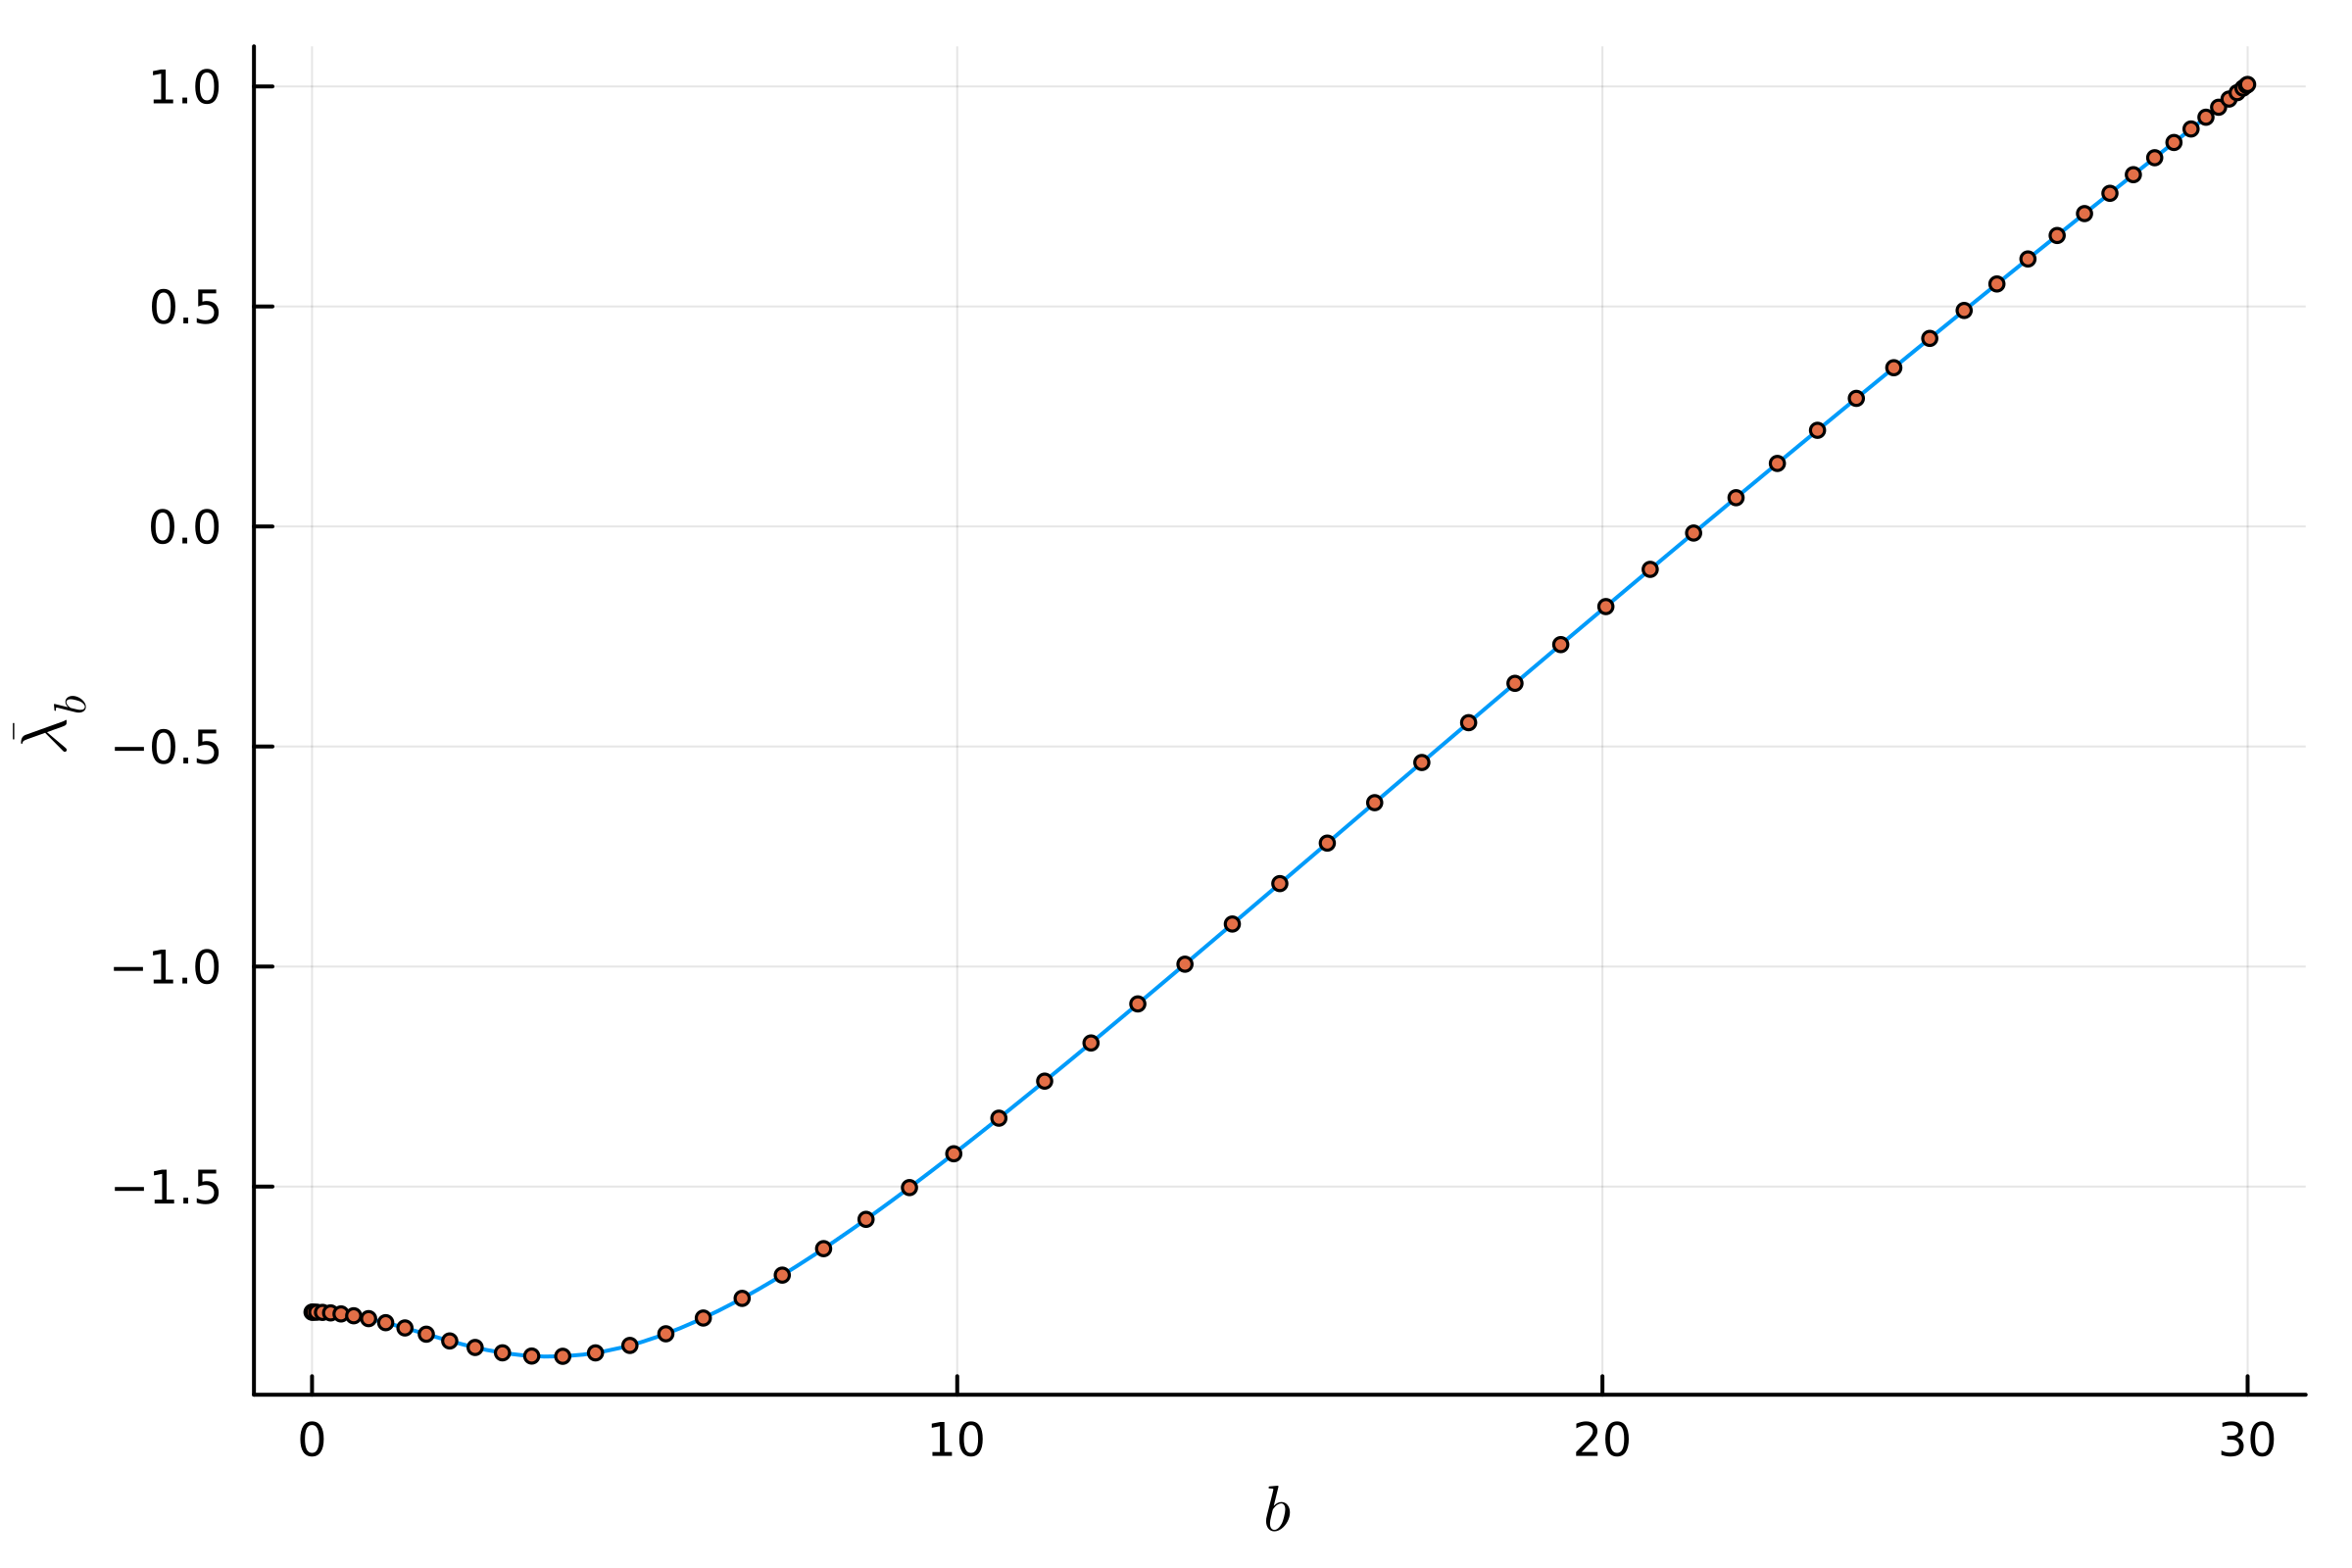

In [26]:
plot(mid.(b), mid.(λ̄.(b)), legend = false, xlabel = L"$b$", ylabel = L"$\bar{\lambda}_b$", dpi = 400)
scatter!(mid.(b2K), mid.(λ̄2K), markershape=:circle, markersize=:2.0, legend = false, dpi = 400)

In [27]:
png("lambda_b")

"lambda_b.png"

### Finding zero of $\lambda_b$ ###

In [31]:
c = copy(b̲)
d = copy(b̄)

ϵ = interval(2^(-10))
while true
    if sup(λ(c+ϵ))< 0
        c += ϵ
    else
        break
    end
end

while true
    if inf(λ(d-ϵ))> 0
        d -= ϵ
    else
        break
    end
end

In [32]:
sup(c)

21.5322265625

In [33]:
inf(d)

21.5380859375